In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import cm
from os.path import exists

ProgressBar().register()

In [2]:
source = 'USP-RegCM471'
source = 'ERA5'
source = 'UCAN-WRF433'
city = 'Porto Alegre'
city = 'Buenos Aires'
city = 'Cordoba'
select = 'heatwaves'
urban_thres = 0.10
land_thres = 0.50
size = 1.5 # degrees plotted around city center
orog_vlim = dict(vmin=-400, vmax=1500)

loc = {
  'Buenos Aires': dict(
    urb = dict(lat = -34.583, lon = -58.500),
    rur = dict(lat = -34.817, lon = -58.533)  # Ezeiza
  ),
  'Cordoba': dict(
    urb = dict(lat = -31.400, lon = -64.167),
    # rur = dict(lat = -31.317, lon = -64.167) # Aero
    rur = dict(lat = -31.3, lon = -64.127) # Aero moved to non-urban gridcell
  ),
  'Porto Alegre': dict( # made up points
    urb = dict(lat = -30.032, lon = -51.174),
    rur = dict(lat = -30.152, lon = -51.061)
  ),
}

ylim_var = dict(tas = (280,310), sfcWind = (0,6), hurs = (30,100))
ylim_vardiff = dict(tas = (-1,3), sfcWind = (-2,0), hurs = (-15,10))

urls_fx = {
  'UCAN-WRF433' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/CORDEX_output_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx',
  'USP-RegCM471' : 
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/1hr/CORDEX_output_CSAM-4_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_1hr', 
  'ERA5' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_1hr',
}

urls_1hr = {
  'UCAN-WRF433' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/1hr/CORDEX_output_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_1hr',
  'USP-RegCM471' : 
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/3hr/CORDEX_output_CSAM-4i_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_3hr', 
  'ERA5' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_1hr',
}

MODIS_LAND_USE = {
  'Urban and built-up': 13,
  'Water bodies': 17
}

pcity = city.replace(" ","")

In [3]:
ucdb_info = gpd.read_file('data/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
ucdb_city = ucdb_info.query(f'UC_NM_MN =="{city}"').to_crs(crs = 'EPSG:4326')
clon = ucdb_city.centroid.x.values[0]
clat = ucdb_city.centroid.y.values[0]

/tmp/ipykernel_301494/75094153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clon = ucdb_city.centroid.x.values[0]
/tmp/ipykernel_301494/75094153.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clat = ucdb_city.centroid.y.values[0]


In [4]:
if source != 'UCAN-WRF433':
  hrds = xr.open_dataset(urls_1hr[source], chunks=dict(lon=10, lat=10))
else:
  fxds = xr.open_dataset(urls_fx[source])
  hrds = xr.open_dataset(urls_1hr[source], chunks=dict(rlon=10, rlat=10))

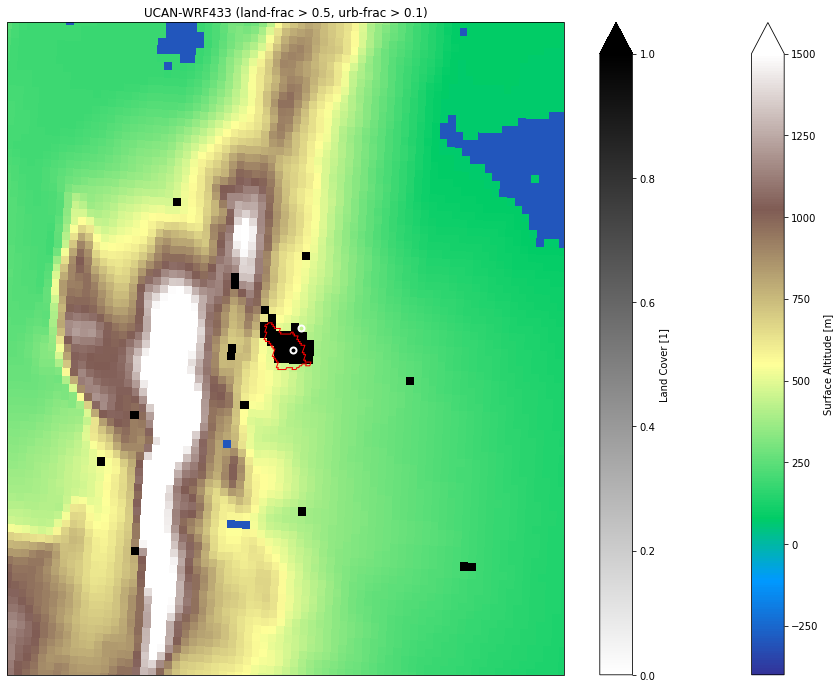

In [5]:
lonlat = ccrs.PlateCarree()
proj = lonlat
f = plt.figure(figsize=(16,12))
ax = plt.axes(projection=proj)
fxds.orog.where(fxds.sftlf == 1).fillna(orog_vlim['vmin']+100).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.terrain, **orog_vlim
)
fxds.landuse.where(fxds.landuse == MODIS_LAND_USE['Urban and built-up']).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.gray_r, vmin=0, vmax=1
)
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
plt.title(f'{fxds.model_id} (land-frac > {land_thres}, urb-frac > {urban_thres})')
lons, lats = list(zip(*[(site['lon'], site['lat']) for site in loc[city].values()]))
ax.plot(lons, lats, 'o', markeredgecolor='w', markeredgewidth=2, markerfacecolor='none', transform=lonlat)
#ax.coastlines(resolution='10m', linewidth=1, color='k')
ucdb_city.plot(ax=ax, transform=lonlat, facecolor="none", edgecolor="red")
plt.savefig(f'figs/{pcity}_{source}.png', facecolor='white')

```python
f = plt.figure(figsize=(12,12))
ax = plt.axes(projection=proj)
fxds.landuse.plot(ax=ax, x='lon', y='lat', transform=lonlat, cmap='tab20c')
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
```

In [6]:
def get_var_ts(ds, var, target_lon, target_lat, geods=None, is_curvilinear=True):
  '''Retrieve time series for a given variable closest to a target location'''
  if is_curvilinear:
    if geods is None:
      geods = ds
    dist = (geods['lon']-target_lon)**2 + (geods['lat']-target_lat)**2
    [ilat], [ilon] = np.where(dist == np.min(dist))
    return(ds[var].isel(rlat=ilat, rlon=ilon))
  else:
    return(ds[var].sel(lat=target_lat, lon=target_lon, method='nearest'))

In [7]:
if select == 'heatwaves':
  htas = get_var_ts(hrds, 'tas', loc[city]['urb']['lon'], loc[city]['urb']['lat'], geods=fxds).compute()
  tasmax = htas.resample(time='1D').max()
  summer = tasmax.time.dt.season == 'DJF'
  p90summer = tasmax[summer].quantile(0.9, dim='time').values
  tasmaxs = tasmax.to_series().reset_index()
# runs not working properly yet:
#tasmaxs.tas[tasmaxs.tas>p90summer].plot()
#runs = (tasmaxs
#  .groupby((tasmaxs.tas>p90summer).cumsum())
#  .agg(
#    since = ('time', 'first'),
#    until = ('time', 'last'),
#    tas = ('tas', 'first'),
#    rlen = ('tas', 'size')
#  )
#)
  # select just days exceeding summer p90
  event_days = tasmaxs.time[(tasmaxs.tas>p90summer)].values

[########################################] | 100% Completed | 13.6s


[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed | 17.3s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed | 17.2s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.4s


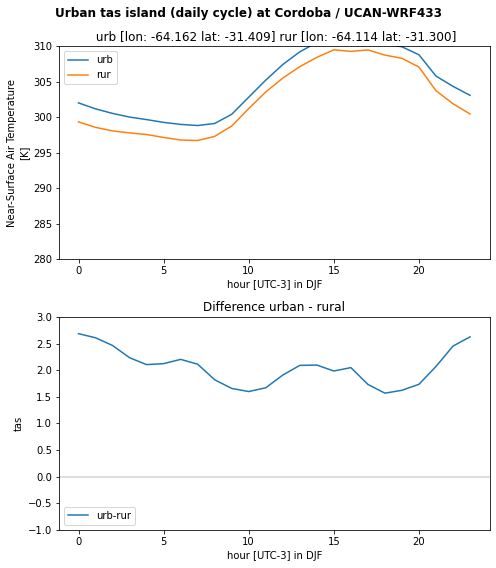

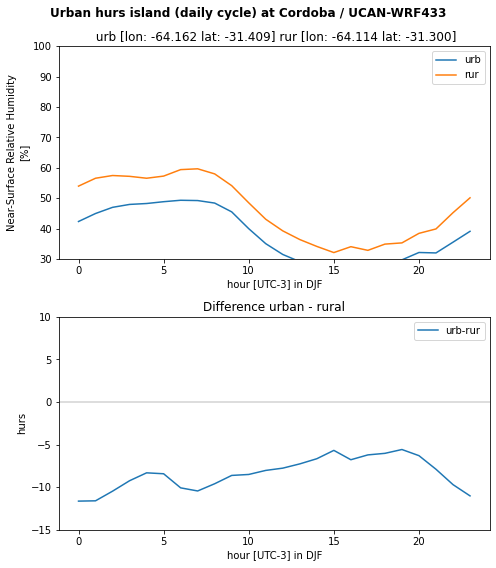

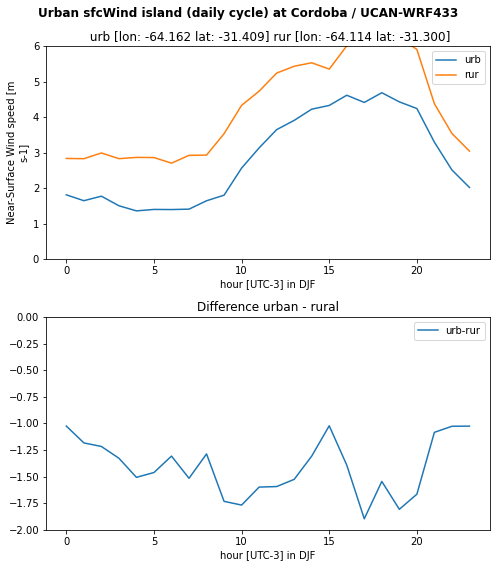

In [8]:
for var in ['tas', 'hurs', 'sfcWind']:
  ts = {}
  sites = ['urb', 'rur']
  for site in sites:
    if var == 'sfcWind':
      u = get_var_ts(hrds, 'uas', loc[city][site]['lon'], loc[city][site]['lat'], geods=fxds).compute()
      v = get_var_ts(hrds, 'vas', loc[city][site]['lon'], loc[city][site]['lat'], geods=fxds).compute()
      ts[site] = np.sqrt(u**2 + v**2)
      ts[site].attrs.update(long_name = 'Near-Surface Wind speed', units = 'm s-1')
    else:
      ts[site] = get_var_ts(hrds, var, loc[city][site]['lon'], loc[city][site]['lat'],
        geods=fxds, is_curvilinear = source=='UCAN-WRF433'
      ).compute()

  seasons = ['DJF', 'JJA', 'ann']
  for season in seasons:
    if season == 'ann':
      tfilter = ts[site].time.dt.season != season
    else:
      tfilter = ts[site].time.dt.season == season
    if select != 'all':
      # There must be a simpler way
      hwfilter = pd.Series([pd.Timestamp(item).to_datetime64() for item in ts[site].time.dt.date.values]).isin(event_days).values
      tfilter = tfilter.values & hwfilter
    dc = {}
    for site in sites:
      dc[site] = ts[site].sel(time=tfilter).groupby('time.hour').mean(dim='time')

    f, ax = plt.subplots(2,1, figsize=(7,8))
    title = ''
    if source == 'USP-RegCM471': # 3hr data
      ilocalshift=-1; localshift = -3
    else:
      ilocalshift=-3; localshift = ilocalshift
    for site in sites:
      dc[site].roll(hour=ilocalshift).plot(ax = ax[0])
      title += f' {site} [lon: {dc[site].lon.values:.3f} lat: {dc[site].lat.values:.3f}]'
    ax[0].set_title(title)
    ax[0].set_xlabel(f'hour [UTC{localshift}] in {season}')
    if select == 'heatwaves' and var == 'tas':
      ax[0].axhline(y=p90summer, color='lightgrey', linestyle=':')
    ax[0].set_ylim(ylim_var[var])
    ax[0].legend(sites)

    (dc['urb']-dc['rur']).roll(hour=ilocalshift).plot(ax=ax[1])
    ax[1].set_title(f'Difference urban - rural')
    ax[1].set_xlabel(f'hour [UTC{localshift}] in {season}')
    ax[1].axhline(y=0, color='lightgrey')
    ax[1].set_ylim(ylim_vardiff[var])
    ax[1].legend(['urb-rur'])
  
    f.suptitle(f'Urban {var} island (daily cycle) at {city} / {source}', weight='bold')
    f.tight_layout()

    if select == 'all':
      figname = f'figs/UHI_{var}_{pcity}_{source}_dc_{season}.png'
    else:
      figname = f'figs/UHI_{var}_{pcity}_{source}_dc_{season}_{select}.png'
    plt.savefig(figname, facecolor='white')
    
    if select == 'heatwaves':
      # just meaningful for summer (DJF)
      break